# Title

# Introduction

provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report

clearly state the question you tried to answer with your project

identify and describe the dataset that was used to answer the question

## Methods and results

describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.

your report should include code which:

loads data from the original source on the web 

wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis

performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 

creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis

performs the data analysis

creates a visualization of the analysis 

note: all tables and figure should have a figure/table number and a legend

### Methods description

Choosing predictors: 

- 

We will build predictive models through the K-nearest neighbor classification algorithm, and evaluate to find the accuracy-maximizing classifier. Our methods involve:
- Create a recipe to centre and scale data.
- Cross-validate and tune the classifier and  to find appropriate number of neighbors.
- Create a model followed by workflow to fit the training data.
- Filter out accuracies and plot against the number of neighbours.
- Fit the best model to testing data.
- Other than the line plot of accuracies vs. number of neighbours, we can also create scatterplot of predictor variables and color the points by outcome level. We can also have side-by-side bar plots showing actual and predicted number of knowledge levels. 

### Codes used

In [4]:
library(tidyverse)
library(tidymodels)
library(readxl)
library(ggplot2)
library(gridExtra)
library(repr)
install.packages("psych")
library(psych)
library(GGally)
options(repr.plot.width = 15, repr.plot.height = 10)

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Search for functions across packages at https://www.tidymodels.org/find/


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


also installing the dependency ‘mnormt’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done


Attaching package: ‘psych’


Th

1. Load data from original source, which is already split into training/testing data. Then show small sections of the data.

In [29]:
train_data <- read_csv("https://raw.githubusercontent.com/fyang1419/group-56-project/main/train_data.csv") |>
select(STG:UNS)

test_data <- read_csv("https://raw.githubusercontent.com/fyang1419/group-56-project/main/test_data.csv") |>
select(STG:UNS)
         
head(train_data)
head(test_data)

New names:
• `` -> `...1`
• `...7` -> `...8`
• `...8` -> `...9`
Rows: 258 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): UNS, Attribute Information:
dbl (6): ...1, STG, SCG, STR, LPR, PEG
lgl (2): ...8, ...9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
• `...7` -> `...8`
• `...8` -> `...9`
Rows: 145 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): UNS, Attribute Information:
dbl (6): ...1, STG, SCG, STR, LPR, PEG
lgl (2): ...8, ...9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
0.20,0.20,0.68,0.67,0.85,High
0.22,0.22,0.90,0.30,0.90,High
0.14,0.14,0.70,0.50,0.30,Low


2. Wrangle and clean data

For our data, show that there are no NA values. And since all the predictors are on the same numerical scale of measurements, they are in tidy format. The only adjustment here is change our target variable from character to factor type. 


In [33]:
#tidy data: turn UNS into factors in both sets of data
train_data <- train_data |>
mutate(UNS = factor(UNS, levels=c('very_low','Low','Middle','High')))

test_data <- test_data |>
mutate(UNS = factor(UNS, levels=c('very_low','Low','Middle','High')))

3. Exploratory data analysis: summary statistics. 

We constructed a summary table for predictors in train-data, as well as a count table for response variable. 

As the summary table shows, the predictors are close in many aspects. All the predictors have the same amount of values (258), same minimum value of 0. Their means range from about 0.36 to about 0.47, their standard deviation ranges from about 0.21 to about 0.26, and their standard error ranges from about 0.013 to about 0.016. Their maximum values ranges from 0.90 to 0.99, which are the same as their ranges. 

The count table for the response variable suggest an unbalanced distribution of levels. The "Middle" level has the maximum count of 88, while the "very_low" level only has 24 points.

In [34]:
summary_pred_train <- describe(train_data[-6], fast=TRUE)
summary_pred_train

UNS_count <- train_data |>
group_by(UNS) |>
    summarise(count = n())
UNS_count

,vars,n,mean,sd,min,max,range,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
STG,1,258,0.3711473,0.2102712,0,0.99,0.99,0.01309091
SCG,2,258,0.3556744,0.2119623,0,0.90,0.90,0.01319620
STR,3,258,0.4680039,0.2459398,0,0.95,0.95,0.01531154
LPR,4,258,0.4327132,0.2481080,0,0.99,0.99,0.01544653
PEG,5,258,0.4585388,0.2552109,0,0.93,0.93,0.01588874


UNS,count
<fct>,<int>
very_low,24
Low,83
Middle,88
High,63


4. Exploratory data analysis: visualization

To have an overall image of the continuous predictors, we used "ggpairs" function from the ggplot2 package. 

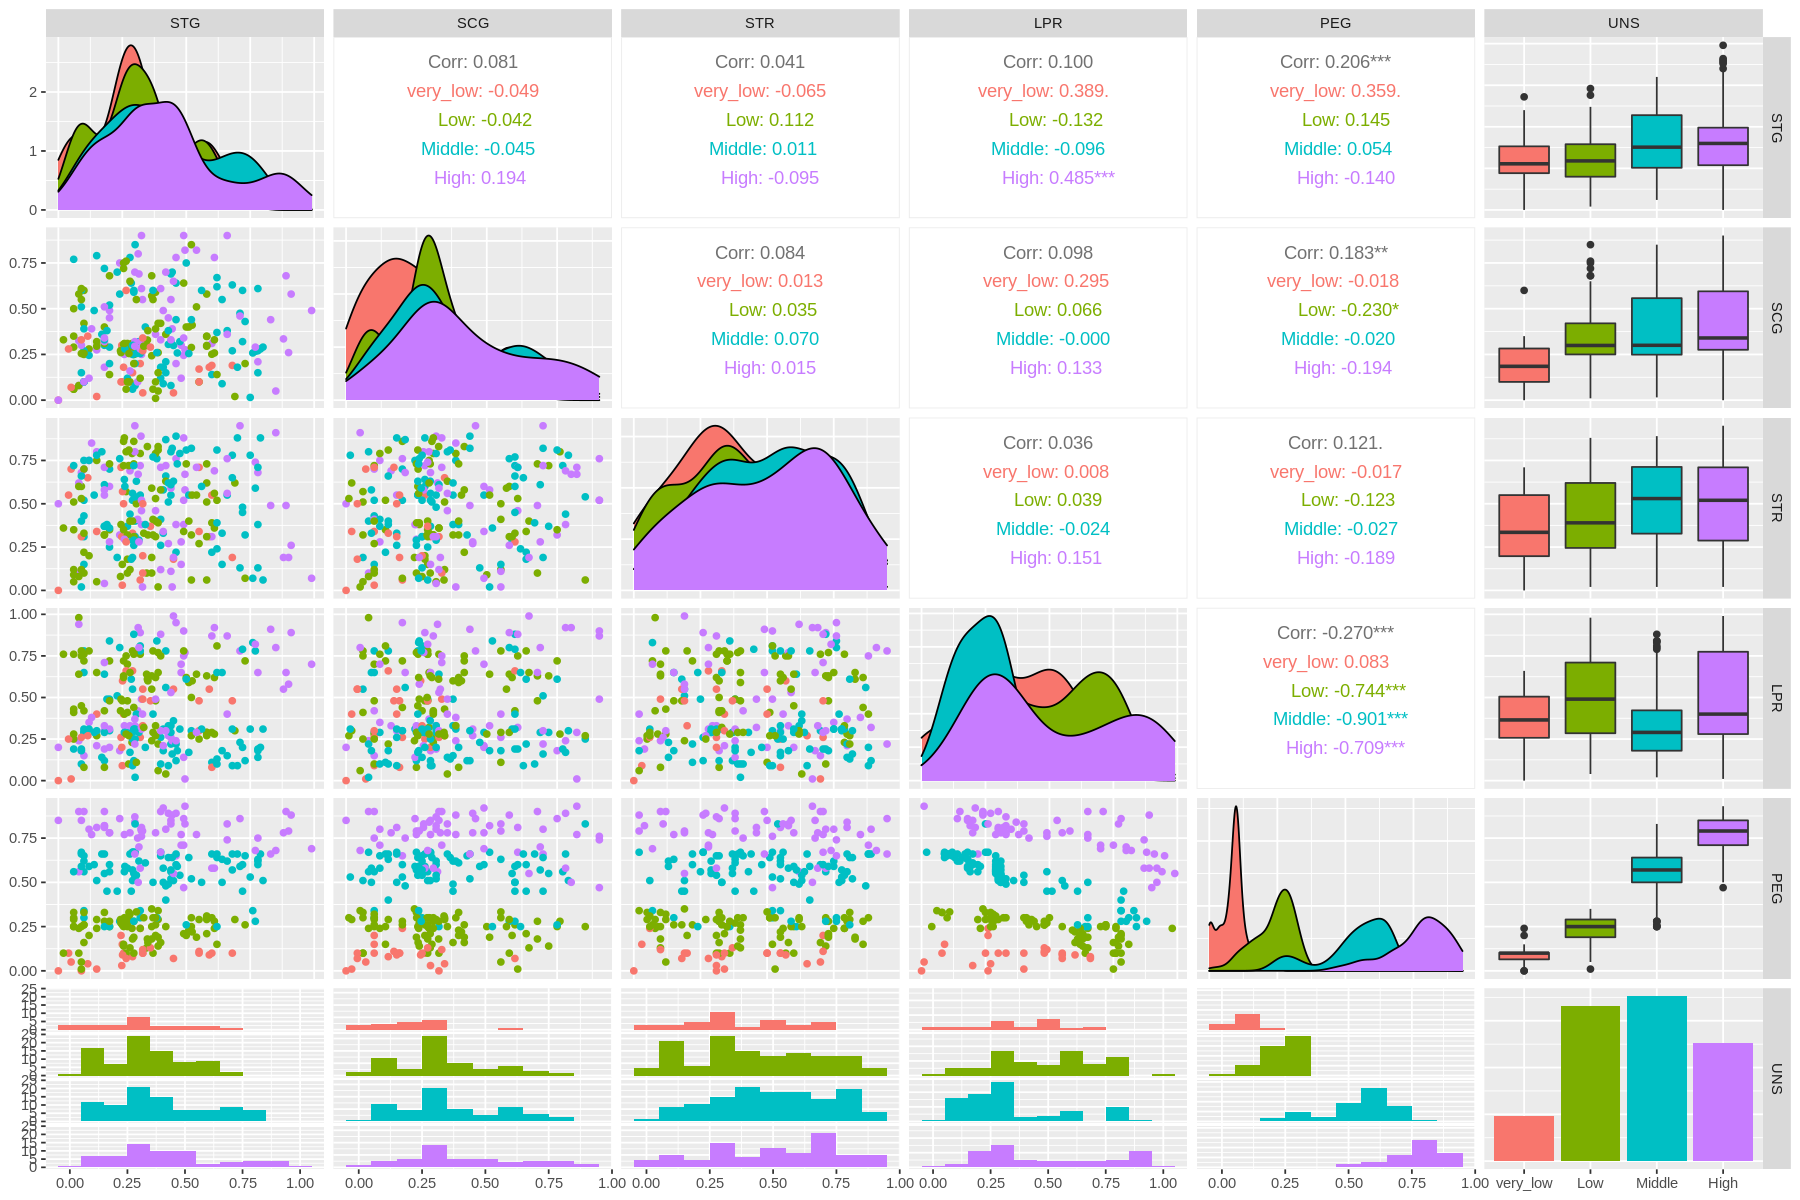

In [36]:
ggpairs(train_data, aes(color=UNS),
       lower = list(combo = wrap("facethist", binwidth = 0.1)))

5. Data analysis

In [3]:
set.seed(1)
vfold <- vfold_cv(train_data, v = 5, strata = UNS)

recipe <- recipe(UNS ~ STG+STR+PEG, data = train_data) |> 
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

gridvals <- tibble(neighbors = seq(from = 1, to = 50, by = 2)) 

knn_results <- workflow() |>
  add_recipe(recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = vfold, grid = gridvals) |>
  collect_metrics() 
accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies

ERROR: Error in vfold_cv(train_data, v = 5, strata = UNS): could not find function "vfold_cv"


## Discussion

summarize what you found

discuss whether this is what you expected to find?

discuss what impact could such findings have?

discuss what future questions could this lead to?

## References

At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
Make sure to cite the source of your data as well.

Source for ggpairs: https://www.rdocumentation.org/packages/GGally/versions/1.5.0/topics/ggpairs